# Models Comparison for TinyML

In [159]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
from pandas import read_csv
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [160]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)

In [144]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [145]:
labels = 2
samples = 150
X = X[:labels*samples]
y = y[:labels*samples]

In [146]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)

In [148]:
scaler = RobustScaler()

In [149]:
X_test.shape

(90, 32)

In [150]:
y = np.array(y)


## Model Spotting

In [151]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [152]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
models.append(('RF', RandomForestClassifier(random_state=seed, n_estimators = 50)))


In [153]:
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_train = scaler.fit_transform(X_cross_train)
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        X_cross_test = scaler.transform(X_cross_test)
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,51 0,09
LR - 0,56 0,07
CART - 0,57 0,06
SVC - 0,69 0,08
RF - 0,71 0,09


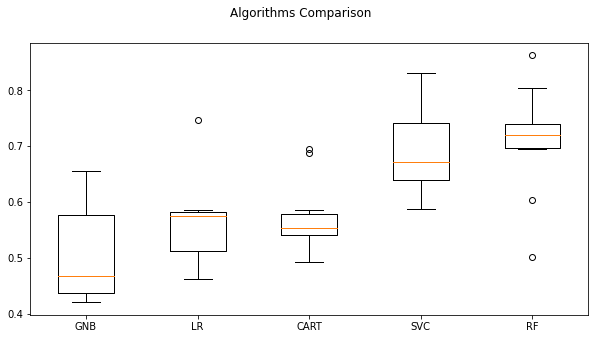

In [154]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

# Valutazione modelli sul Test Set

In [155]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    print(classification_report(y_test, pred_test))
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.36      0.13      0.20        30
           1       0.65      0.43      0.52        30
           2       0.42      0.83      0.56        30

    accuracy                           0.47        90
   macro avg       0.48      0.47      0.43        90
weighted avg       0.48      0.47      0.43        90

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.49      0.57      0.52        30
           1       0.62      0.50      0.56        30
           2       0.52      0.53      0.52        30

    accuracy                           0.53        90
   macro avg       0.54      0.53      0.53        90
weighted avg       0.54      0.53      0.53        90

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.56

### Neural Network

In [156]:
model = Sequential(name="Sequential-NN")
model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
model.add(layers.Dense(np.unique(y).size * 5, activation='relu'))
model.add(layers.Dense(np.unique(y).size, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Convert to array[int]
y_train = np.array([int(num) for num in y_train])
y_test = np.array([int(num) for num in y_test])

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_55 (Dense)             (None, 15)                495       
_________________________________________________________________
dense_56 (Dense)             (None, 3)                 48        
Total params: 1,599
Trainable params: 1,599
Non-trainable params: 0
_________________________________________________________________


## Train and Test

In [157]:
EPOCHS = 500
BATCH_SIZE = 32
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/500
12/12 [==============================] - 0s 1ms/step - loss: 1.1680 - accuracy: 0.3194
Epoch 2/500
12/12 [==============================] - 0s 786us/step - loss: 1.0270 - accuracy: 0.4417
Epoch 3/500
12/12 [==============================] - 0s 595us/step - loss: 0.9698 - accuracy: 0.4917
Epoch 4/500
12/12 [==============================] - 0s 644us/step - loss: 0.9353 - accuracy: 0.5472
Epoch 5/500
12/12 [==============================] - 0s 598us/step - loss: 0.9087 - accuracy: 0.5806
Epoch 6/500
12/12 [==============================] - 0s 1ms/step - loss: 0.8867 - accuracy: 0.6028
Epoch 7/500
12/12 [==============================] - 0s 715us/step - loss: 0.8676 - accuracy: 0.6361
Epoch 8/500
12/12 [==============================] - 0s 666us/step - loss: 0.8504 - accuracy: 0.6639
Epoch 9/500
12/12 [==============================] - 0s 527us/step - loss: 0.8364 - accuracy: 0.6667
Epoch 10/500
12/12 [==============================] - 0s 820us/step - loss: 0.8230 - accuracy: 

12/12 [==============================] - 0s 701us/step - loss: 0.3418 - accuracy: 0.8889
Epoch 82/500
12/12 [==============================] - 0s 826us/step - loss: 0.3376 - accuracy: 0.8889
Epoch 83/500
12/12 [==============================] - 0s 342us/step - loss: 0.3349 - accuracy: 0.8917
Epoch 84/500
12/12 [==============================] - 0s 1ms/step - loss: 0.3295 - accuracy: 0.8917
Epoch 85/500
12/12 [==============================] - 0s 581us/step - loss: 0.3274 - accuracy: 0.8972
Epoch 86/500
12/12 [==============================] - 0s 1ms/step - loss: 0.3275 - accuracy: 0.9083
Epoch 87/500
12/12 [==============================] - 0s 493us/step - loss: 0.3260 - accuracy: 0.8917
Epoch 88/500
12/12 [==============================] - 0s 943us/step - loss: 0.3172 - accuracy: 0.9028
Epoch 89/500
12/12 [==============================] - 0s 351us/step - loss: 0.3141 - accuracy: 0.9111
Epoch 90/500
12/12 [==============================] - 0s 762us/step - loss: 0.3091 - accuracy: 0.90

12/12 [==============================] - 0s 1ms/step - loss: 0.1391 - accuracy: 0.9806
Epoch 162/500
12/12 [==============================] - 0s 352us/step - loss: 0.1395 - accuracy: 0.9722
Epoch 163/500
12/12 [==============================] - 0s 638us/step - loss: 0.1332 - accuracy: 0.9694
Epoch 164/500
12/12 [==============================] - 0s 350us/step - loss: 0.1301 - accuracy: 0.9750
Epoch 165/500
12/12 [==============================] - 0s 1ms/step - loss: 0.1301 - accuracy: 0.9833
Epoch 166/500
12/12 [==============================] - 0s 595us/step - loss: 0.1323 - accuracy: 0.9778
Epoch 167/500
12/12 [==============================] - 0s 1ms/step - loss: 0.1287 - accuracy: 0.9694
Epoch 168/500
12/12 [==============================] - 0s 552us/step - loss: 0.1263 - accuracy: 0.9750
Epoch 169/500
12/12 [==============================] - 0s 878us/step - loss: 0.1239 - accuracy: 0.9833
Epoch 170/500
12/12 [==============================] - 0s 490us/step - loss: 0.1213 - accurac

12/12 [==============================] - 0s 957us/step - loss: 0.0551 - accuracy: 0.9972
Epoch 242/500
12/12 [==============================] - 0s 705us/step - loss: 0.0547 - accuracy: 0.9972
Epoch 243/500
12/12 [==============================] - 0s 1ms/step - loss: 0.0546 - accuracy: 0.9972
Epoch 244/500
12/12 [==============================] - 0s 667us/step - loss: 0.0532 - accuracy: 0.9972
Epoch 245/500
12/12 [==============================] - 0s 807us/step - loss: 0.0559 - accuracy: 0.9972
Epoch 246/500
12/12 [==============================] - 0s 340us/step - loss: 0.0543 - accuracy: 0.9972
Epoch 247/500
12/12 [==============================] - 0s 1ms/step - loss: 0.0524 - accuracy: 0.9972
Epoch 248/500
12/12 [==============================] - 0s 369us/step - loss: 0.0517 - accuracy: 0.9972
Epoch 249/500
12/12 [==============================] - 0s 1ms/step - loss: 0.0508 - accuracy: 0.9972
Epoch 250/500
12/12 [==============================] - 0s 378us/step - loss: 0.0499 - accurac

12/12 [==============================] - 0s 424us/step - loss: 0.0241 - accuracy: 0.9972
Epoch 322/500
12/12 [==============================] - 0s 711us/step - loss: 0.0243 - accuracy: 1.0000
Epoch 323/500
12/12 [==============================] - 0s 356us/step - loss: 0.0232 - accuracy: 1.0000
Epoch 324/500
12/12 [==============================] - 0s 1ms/step - loss: 0.0233 - accuracy: 1.0000
Epoch 325/500
12/12 [==============================] - 0s 537us/step - loss: 0.0227 - accuracy: 1.0000
Epoch 326/500
12/12 [==============================] - 0s 905us/step - loss: 0.0224 - accuracy: 1.0000
Epoch 327/500
12/12 [==============================] - 0s 456us/step - loss: 0.0229 - accuracy: 1.0000
Epoch 328/500
12/12 [==============================] - 0s 996us/step - loss: 0.0228 - accuracy: 0.9972
Epoch 329/500
12/12 [==============================] - 0s 667us/step - loss: 0.0228 - accuracy: 1.0000
Epoch 330/500
12/12 [==============================] - 0s 667us/step - loss: 0.0222 - acc

12/12 [==============================] - 0s 686us/step - loss: 0.0108 - accuracy: 1.0000
Epoch 401/500
12/12 [==============================] - 0s 667us/step - loss: 0.0109 - accuracy: 1.0000
Epoch 402/500
12/12 [==============================] - 0s 352us/step - loss: 0.0106 - accuracy: 1.0000
Epoch 403/500
12/12 [==============================] - 0s 597us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 404/500
12/12 [==============================] - 0s 551us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 405/500
12/12 [==============================] - 0s 667us/step - loss: 0.0104 - accuracy: 1.0000
Epoch 406/500
12/12 [==============================] - 0s 323us/step - loss: 0.0102 - accuracy: 1.0000
Epoch 407/500
12/12 [==============================] - 0s 955us/step - loss: 0.0101 - accuracy: 1.0000
Epoch 408/500
12/12 [==============================] - 0s 547us/step - loss: 0.0103 - accuracy: 1.0000
Epoch 409/500
12/12 [==============================] - 0s 1ms/step - loss: 0.0099 - acc

12/12 [==============================] - 0s 350us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 481/500
12/12 [==============================] - 0s 1ms/step - loss: 0.0051 - accuracy: 1.0000
Epoch 482/500
12/12 [==============================] - 0s 436us/step - loss: 0.0050 - accuracy: 1.0000
Epoch 483/500
12/12 [==============================] - 0s 667us/step - loss: 0.0051 - accuracy: 1.0000
Epoch 484/500
12/12 [==============================] - 0s 169us/step - loss: 0.0049 - accuracy: 1.0000
Epoch 485/500
12/12 [==============================] - 0s 407us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 486/500
12/12 [==============================] - 0s 678us/step - loss: 0.0048 - accuracy: 1.0000
Epoch 487/500
12/12 [==============================] - 0s 982us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 488/500
12/12 [==============================] - 0s 610us/step - loss: 0.0047 - accuracy: 1.0000
Epoch 489/500
12/12 [==============================] - 0s 1ms/step - loss: 0.0047 - accur

In [158]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
print(classification_report(y_test, predictions_categorical))

              precision    recall  f1-score   support

           0       0.52      0.57      0.54        30
           1       0.54      0.63      0.58        30
           2       0.68      0.50      0.58        30

    accuracy                           0.57        90
   macro avg       0.58      0.57      0.57        90
weighted avg       0.58      0.57      0.57        90



# Valutazione Inferance Rate medio (|X_test| = 40)

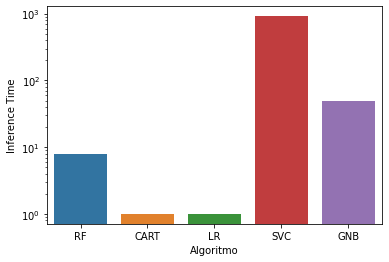

In [316]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

# Memoria occupata

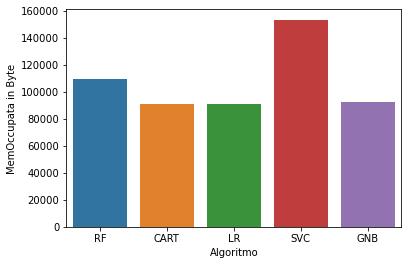

In [20]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Export Models in C code

In [162]:
with open('exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))
for name, model in models:
    prepath = 'exportedModels/' + str(labels) + "/"
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: C:\Users\LUIGI~1.BOR\AppData\Local\Temp\tmp3oo9kle8\assets
